In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15,8)})

path_to_catalog=r'C:\Users\kgrzebien\Desktop\python_tasks\reklamacje\\'


In [2]:
def func_read_data(path):
    df=pd.read_csv(path+'.csv',
              encoding='Cp1250',
              sep="|")
    return df
def func_numer_faktury(df):
    df['FAKTURA_NUMER']=df['FAKTURA'].apply(lambda x: x[4:])
    return df
    
def func_str_to_float(s):
    s=s.astype(str)
    s=s.apply(lambda x: x.replace(',','.'))
    s=s.astype(float)
    return s

def func_add_time(df):
    
    df['Z_DNIA']=pd.to_datetime(df['Z_DNIA'], format='%y/%m/%d')
    
    df['year']=df['Z_DNIA'].apply(lambda x: x.year)
    df['month']=df['Z_DNIA'].apply(lambda x: x.month)
    df['day_of_year']=df['Z_DNIA'].apply(lambda x: x.timetuple().tm_yday)
    df['week']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[1])
    df['week_day']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[2])
    df['year_month']=df['year'].astype(str)+'-'+df['month'].astype(str)+'-'+'01'
    df['year_month']=df['year_month'].apply(lambda x: x[:5]+'0'+x[5:] if len(x)==9 else x)
    df['year_month']=pd.to_datetime(df['year_month'], format='%Y-%m-%d')
    df['year_week']=df['year'].astype(str)+'--'+df['week'].astype(str)
    df['year_week']=df['year_week'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)==7 else x)
    df['year_day']=df['year'].astype(str)+'--'+df['day_of_year'].astype(str)
    df['year_day']=df['year_day'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)<9 else x)
    return df

def func_add_kod_fili(df, col_kod):
    df_filia=pd.read_csv('../słowniki/filie.csv',
                         encoding='Cp1250',
                          sep="|")
    df_filia=df_filia.loc[df_filia['IS_DELETED']=='N'][['KOD','ANALIT01','ANALIT02']]
    df_filia.loc[df_filia.loc[df_filia['KOD']=='LI'].index, 'ANALIT01']='LI'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='LI'].index, 'ANALIT02']='LIKWIDACJA'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='00'].index, 'ANALIT01']='00'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='00'].index, 'ANALIT02']='MAGAZYN_00'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='65'].index, 'ANALIT01']='FE'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='65'].index, 'ANALIT02']='FELER'
    df=df.merge(df_filia, how='left', left_on=col_kod, right_on='KOD')
    return df

def func_add_slownik(df):
    df_slownik=pd.read_csv('../słowniki/slownik.csv',
                           encoding='Cp1250',
                          sep="|")
    df_slownik=df_slownik.loc[df_slownik['IS_DELETED']=='N'][['KOD_TEMA','ZNACZNIK','DOSTAWCA']]
    df=df.merge(df_slownik, how='left', on='KOD_TEMA')
    df=func_add_znacznik(df)
    return df

def func_add_znacznik(df):
    df_znacznik=pd.read_csv('../słowniki/znacznik.csv',
                            encoding='Cp1250',
                              sep="|")
    df_znacznik=df_znacznik.loc[df_znacznik['IS_DELETED']=='N'][['ZNACZNIK','NAZWA']]
    df_znacznik=df_znacznik.rename(columns={'NAZWA':'NAZWA_ZNACZNIK'})
    df=df.merge(df_znacznik, how='left', on='ZNACZNIK')
    return df

def func_sell(path):
    df=pd.read_csv('../sprzedaz_fakty_bi/'+path+'.csv',
                            encoding='Cp1250',
                              sep="|")
    df=func_add_slownik(df)
    df=func_add_time(df)
    df['WARTOB_SUM']=func_str_to_float(df['WARTOB_SUM'])
    df['ILOSC_SUM']=func_str_to_float(df['ILOSC_SUM'])
    df=func_add_kod_fili(df, 'FILIA')
    return df

def func_nazwa_szac(df):
    df['NAZWA1_BEZ_F']=df['NAZWA1'].apply(lambda x: x[2:] if x[:2]=='F/' else x)
    return df

In [3]:
df_sell=func_sell('hurtbi_fakty_sprz_22')


In [11]:
df_fi=func_read_data('f56fi_wszystkie_kody_fili_cena_pozycja')
df_fi=func_numer_faktury(df_fi)
df_fi=func_add_slownik(df_fi)
df_fi=func_add_time(df_fi)
df_fi['WARTOSC_B']=func_str_to_float(df_fi['WARTOSC_B'])
df_fi['ILOSC']=func_str_to_float(df_fi['ILOSC'])
df_fi['CENA_POZYCJA']=func_str_to_float(df_fi['CENA_POZYCJA'])
df_fi=func_add_kod_fili(df_fi, 'KOD')

In [5]:
df_szac=func_read_data('f56szac')
df_szac=func_numer_faktury(df_szac)
df_szac=func_add_slownik(df_szac)
df_szac=func_add_time(df_szac)
df_szac['CENA_Z1']=func_str_to_float(df_szac['CENA_Z1'])
df_szac['CENA_Z2']=func_str_to_float(df_szac['CENA_Z2'])
df_szac=func_nazwa_szac(df_szac)

In [86]:
df_szac['uz_nr']=df_szac['UZASADNIEN'].apply(lambda x: x[-8:])

In [29]:
def func_plot_scatter(df, dict_agg, gr,
                     df_sell):
    df_sell=df_sell.loc[df_sell['ILOSC_SUM']>1]
    df=df.loc[df['ANALIT01'].isin(['LI','FE', 'OU'])]
    df_dostawca_produkt=df[['DOSTAWCA','KOD_TEMA']].drop_duplicates()
    df_gr_filtr=df[[gr]].drop_duplicates()
    df_gr=df.groupby(gr).agg(dict_agg).sort_values(by='ILOSC', ascending=False).reset_index()
    df_sell_dostawca_produkt=df_sell.merge(df_dostawca_produkt, how='inner', on=list(df_dostawca_produkt.columns)).\
                                    groupby(gr).agg({'WARTOB_SUM':'sum'}).reset_index()
    df_sell=df_sell.merge(df_gr_filtr, how='inner', on=list(df_gr_filtr.columns)).\
                    groupby(gr).agg({'WARTOB_SUM':'sum',
                                    'ILOSC_SUM':'sum'}).reset_index()
    df_gr=df_gr.merge(df_sell, how='inner', on=gr)
    df_gr['proc']=df_gr['ILOSC']/df_gr['ILOSC_SUM']*100
    display(df_gr.sort_values(by='proc'))
    fig=px.scatter(df_gr,
                  x=gr,
                  y='ILOSC',
                   color='CENA_POZYCJA',
                   size='proc',
                   color_continuous_scale=["red", "green", "blue"],
                  #color='NAZWA_ZNACZNIK',
                  height=600,
                  size_max=60)#,
                  #log_y=True)
    fig.show()
    
    _=df_gr[dict_agg.keys()]/df_gr[dict_agg.keys()].sum()*100
    _1=(df_gr[dict_agg.keys()]/df_gr[dict_agg.keys()].sum()*100).cumsum()
    display(df_gr[[gr]].merge(_, how='left', left_index=True, right_index=True).merge(_1, how='left', left_index=True, right_index=True))
    # display(df_sell_dostawca_produkt)
    # display(df_sell)
    fig.write_html(path_to_catalog+gr+'.html')
    return

,DOSTAWCA,ILOSC,CENA_POZYCJA,WARTOB_SUM,ILOSC_SUM,proc
463,777777,1.0,45.6330,897110.386645,12752.500000,0.007842
356,10789,2.1,42.6195,419893.817668,16421.910000,0.012788
448,F15661,1.0,7.5522,10319.400000,5787.000000,0.017280
202,F10501,11.0,16.2360,30619.924138,37166.816667,0.029596
297,12747,4.0,18.3516,12516.912235,12649.380000,0.031622
...,...,...,...,...,...,...
253,12168,7.0,266.0490,16.380000,3.000000,233.333333
291,12438,5.0,4445.3430,940.100000,2.000000,250.000000
292,12606,5.0,205.4961,235.600000,2.000000,250.000000
75,12762,62.0,328.5945,183.120000,24.000000,258.333333


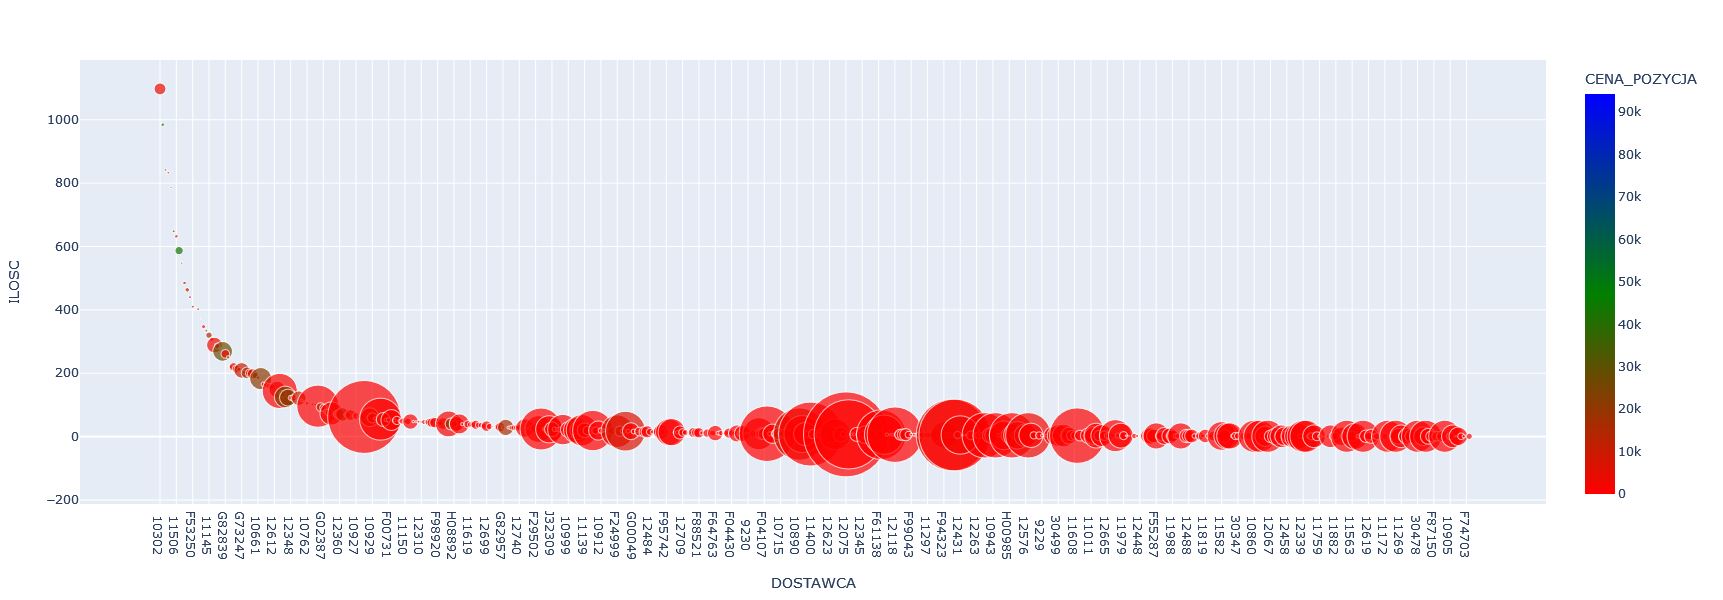

,DOSTAWCA,ILOSC_x,CENA_POZYCJA_x,ILOSC_y,CENA_POZYCJA_y
0,10302,4.580010,0.377094,4.580010,0.377094
1,11447,4.108864,4.610517,8.688874,4.987611
2,H00846,3.512315,3.641728,12.201188,8.629339
3,9469,3.476217,0.150235,15.677405,8.779575
4,11859,3.280080,1.277939,18.957485,10.057513
...,...,...,...,...,...
477,12669,0.004173,0.007153,99.983725,99.987871
478,F76379,0.004173,0.003783,99.987898,99.991654
479,F04471,0.004173,0.005137,99.992071,99.996790
480,F74703,0.004173,0.002051,99.996244,99.998841


In [30]:
func_plot_scatter(df_fi, {'ILOSC':'sum',
                         'CENA_POZYCJA':'sum'},
                  'DOSTAWCA',
                 df_sell)

,NAZWA_ZNACZNIK,ILOSC,CENA_POZYCJA,WARTOB_SUM,ILOSC_SUM,proc
28,USŁUGI SZYCIA,3.00,0.000000,3.394323e+05,7.529186e+05,0.000398
23,ROLETY,25.00,3173.400000,1.243834e+06,1.155801e+05,0.021630
25,REKL.+ETYK.,13.00,60.688200,7.408361e+04,4.417882e+04,0.029426
31,PASM.SALON,1.00,0.000000,1.257422e+04,3.183051e+03,0.031416
30,SPAGETTI,1.00,38.745000,1.206583e+04,1.352000e+03,0.073964
6,TAŚMY,1438.50,2678.273340,1.836660e+06,1.439536e+06,0.099928
27,ŚWIECE,4.00,138.522600,4.654577e+04,3.510000e+03,0.113960
20,KOCE,112.00,5902.979100,2.320924e+06,7.375900e+04,0.151846
29,HOTELE,2.00,52.914600,4.775925e+04,1.279150e+03,0.156354
2,BELKI,2590.33,67302.490143,2.259865e+07,7.847048e+05,0.330102


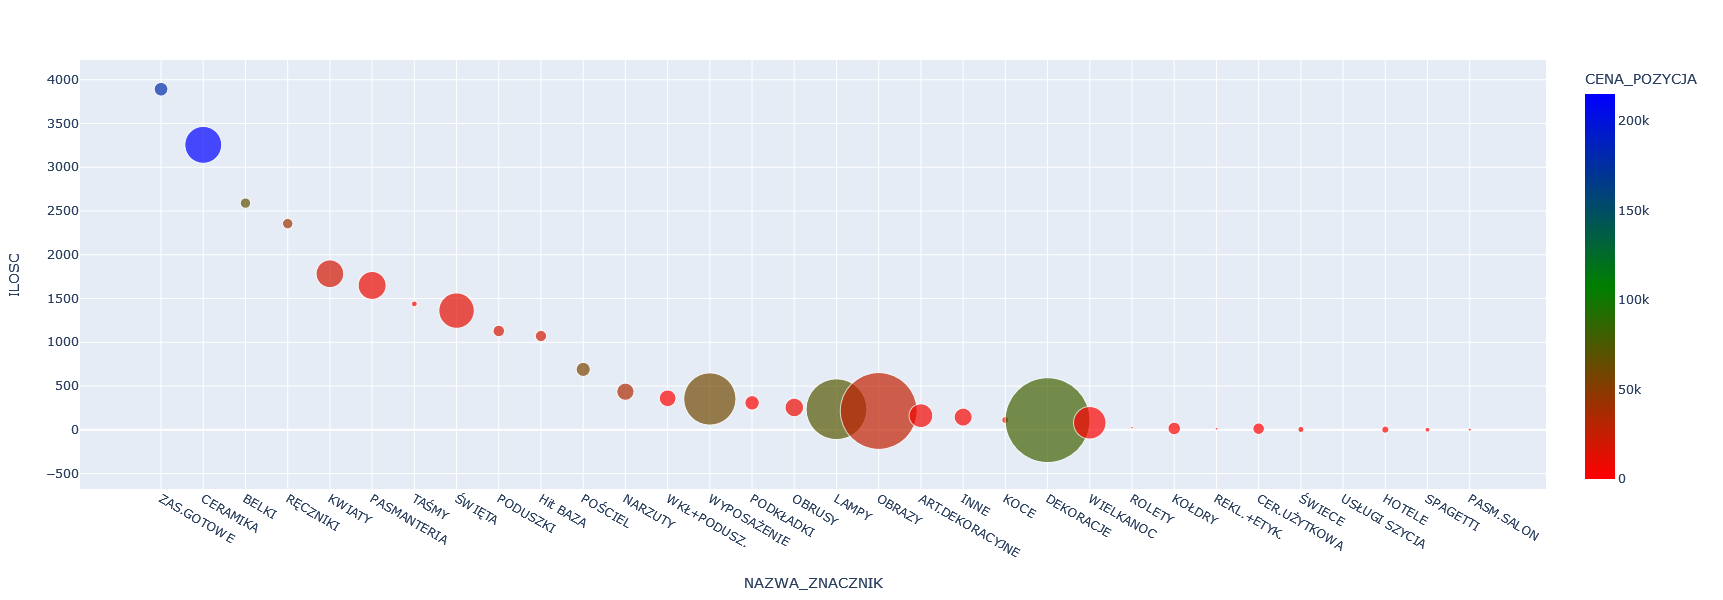

,NAZWA_ZNACZNIK,ILOSC_x,CENA_POZYCJA_x,ILOSC_y,CENA_POZYCJA_y
0,ZAS.GOTOWE,16.174861,18.988377,16.174861,18.988377
1,CERAMIKA,13.531693,22.903104,29.706554,41.891482
2,BELKI,10.765218,7.161453,40.471772,49.052934
3,RĘCZNIKI,9.791360,4.493716,50.263132,53.546650
4,KWIATY,7.410015,1.931314,57.673147,55.477964
5,PASMANTERIA,6.853910,0.799244,64.527058,56.277208
6,TAŚMY,5.978299,0.284987,70.505356,56.562195
7,ŚWIĘTA,5.660370,1.131852,76.165727,57.694047
8,PODUSZKI,4.692040,1.907184,80.857766,59.601231
9,Hit BAZA,4.453490,1.864325,85.311256,61.465556


In [31]:
func_plot_scatter(df_fi, {'ILOSC':'sum',
                         'CENA_POZYCJA':'sum'}, 
                  'NAZWA_ZNACZNIK',
                 df_sell)

In [49]:
len(df_fi)

67133

In [18]:
df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby('DOSTAWCA').agg(sprzedaz_calego_dostawcy=('WARTOB_SUM','sum'),
                                                 sprzedaz_calego_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA'])
df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby(['DOSTAWCA','NAZWA_ZNACZNIK']).agg(sprzedaz_znacznik_dostawcy=('WARTOB_SUM','sum'),
                                                 sprzedaz_znacznik_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA','NAZWA_ZNACZNIK'])
df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby(['DOSTAWCA','KOD_TEMA']).agg(sprzedaz_kod_tema_dostawcy=('WARTOB_SUM','sum'),
                                                 sprzedaz_kod_tema_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA','KOD_TEMA'])

In [19]:
df_fi=df_fi.fillna(0)

In [20]:
df_fi_sell=df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].\
    groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK','RODZAJ','KOD_TEMA']).agg({'ILOSC':'sum',
                                                                               'CENA_POZYCJA':'sum',
                                                                               'Z_DNIA':'nunique',
                                                                               'sprzedaz_calego_dostawcy_ilosc':'first',
                                                                      'sprzedaz_znacznik_dostawcy_ilosc':'first',
                                                                      #'sprzedaz_kod_tema_dostawcy_ilosc':'first',
                                                                     'sprzedaz_calego_dostawcy':'first',
                                                                      'sprzedaz_znacznik_dostawcy':'first'}).reset_index().\
        groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'ILOSC':'sum',
                                                                               'CENA_POZYCJA':'sum',
                                                                               'Z_DNIA':'sum',
                                                                               'sprzedaz_calego_dostawcy_ilosc':'first',
                                                                      'sprzedaz_znacznik_dostawcy_ilosc':'first',
                                                                      #'sprzedaz_kod_tema_dostawcy_ilosc':'first',
                                                                     'sprzedaz_calego_dostawcy':'first',
                                                                      'sprzedaz_znacznik_dostawcy':'first'}).reset_index()

# df_fi_sell=df_fi_sell.merge(df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].\
#                                 groupby(['FAKTURA','ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'WARTOSC_B':'first'}).reset_index().\
#                                 groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'WARTOSC_B':'sum'}).reset_index(),
#                             how='left',
#                             on=['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK'])

In [21]:
len(df_fi_sell.loc[df_fi_sell['ILOSC']>df_fi_sell['sprzedaz_znacznik_dostawcy_ilosc']])

28

In [22]:
len(df_fi_sell)

1144

In [23]:
from sklearn.cluster import KMeans

In [25]:
from sklearn.metrics import silhouette_score
def func_choose_k(x):
    sil = []
    kmax = 6
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    plt.plot(range(2, kmax+1), sil)
    plt.show()

    
def func_odwroc_pred(x, x_centers):
    if x_centers[0][1]>x_centers[1][1]:
        return x
    else:
        for i in range(0,len(x)):
            if x[i]==0:
                x[i]=1
            else:
                x[i]=0
        return x
    
    
def func_cluster(df, znacznik, gdzie, plot=1):
    if znacznik!='':
        df=df.loc[df['NAZWA_ZNACZNIK']==znacznik]
        df=df.loc[df['ANALIT02']==gdzie]
        df=df.loc[df['ILOSC']<=df['sprzedaz_calego_dostawcy_ilosc']]
        df['proc_reklamacji_do_znacznik_dostawca']=df['ILOSC']/df['sprzedaz_znacznik_dostawcy_ilosc']*100
        #display(df.sort_values(by='proc_reklamacji_do_znacznik_dostawca'))
        try:
            kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
            x_pred=kmeans.predict(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
            #print(kmeans.labels_, kmeans.cluster_centers_)
            x_pred=func_odwroc_pred(x_pred, kmeans.cluster_centers_)
            df['pred_cluster']=x_pred
            df['pred_cluster']=df['pred_cluster'].astype(str)
            if plot:
                fig=px.scatter(df,
                               x='ILOSC',
                               color='CENA_POZYCJA',
                               y='proc_reklamacji_do_znacznik_dostawca',
                              color_continuous_scale=["red", "green", "blue"])#px.colors.sequential.solar_r)
                fig.show()
                func_choose_k(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
                
            return df[['NAZWA_ZNACZNIK','ANALIT02', 'DOSTAWCA', 'pred_cluster']]
        except: return
    
    
    else:
        df=df.groupby(['ANALIT02','DOSTAWCA']).agg({'CENA_POZYCJA':'sum',
                                                    'ILOSC':'sum',
                                                       'Z_DNIA':'sum',
                                                       'sprzedaz_calego_dostawcy_ilosc':'first',
                                             'sprzedaz_calego_dostawcy':'first'}).reset_index()
        df=df.loc[df['ILOSC']<=df['sprzedaz_calego_dostawcy_ilosc']]
        df=df.loc[df['ANALIT02']==gdzie]
        df['proc_reklamacji_do_dostawca']=df['ILOSC']/df['sprzedaz_calego_dostawcy_ilosc']*100
        #display(df.corr())
        
        kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['ILOSC','proc_reklamacji_do_dostawca']])
        x_pred=kmeans.predict(df[['ILOSC','proc_reklamacji_do_dostawca']])
        df['pred_cluster']=x_pred
        df['pred_cluster']=df['pred_cluster'].astype(str)
        if plot:
            fig=px.scatter(df,
                           x='ILOSC',
                           color='CENA_POZYCJA',
                           #symbol='ANALIT02',
                           y='proc_reklamacji_do_dostawca',
                              color_continuous_scale=["red", "green", "blue"])
            fig.show()
        func_choose_k(df[['ILOSC','proc_reklamacji_do_dostawca']])
#         x_min, x_max = df['ILOSC'].min(),df['ILOSC'].max()
#         y_min, y_max = df['proc_reklamacji_do_dostawca'].min(),df['proc_reklamacji_do_dostawca'].max()
#         xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

#         # Obtain labels for each point in mesh. Use last trained model.
#         Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

#         # Put the result into a color plot
#         Z = Z.reshape(xx.shape)
#         plt.clf()
#         plt.imshow(
#             Z,
#             interpolation="nearest",
#             extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#             cmap=plt.cm.Paired,
#             aspect="auto",
#             origin="lower",
#         )
#         plt.scatter(x=df['ILOSC'],
#                    y=df['proc_reklamacji_do_dostawca'])
#         plt.scatter(x=kmeans.cluster_centers_[:,0],
#                     y=kmeans.cluster_centers_[:,1],
#                    color='green')
#         plt.show()

In [382]:
_=pd.DataFrame()
for i in df_fi_sell['NAZWA_ZNACZNIK'].unique():
    _=_.append(func_cluster(df_fi_sell, i, 'OUTLET', None))
    #break

In [356]:
_.pivot(index='DOSTAWCA',
       columns='NAZWA_ZNACZNIK',
       values='pred_cluster').to_excel(path_to_catalog+'usun_pivot_outlet.xlsx')

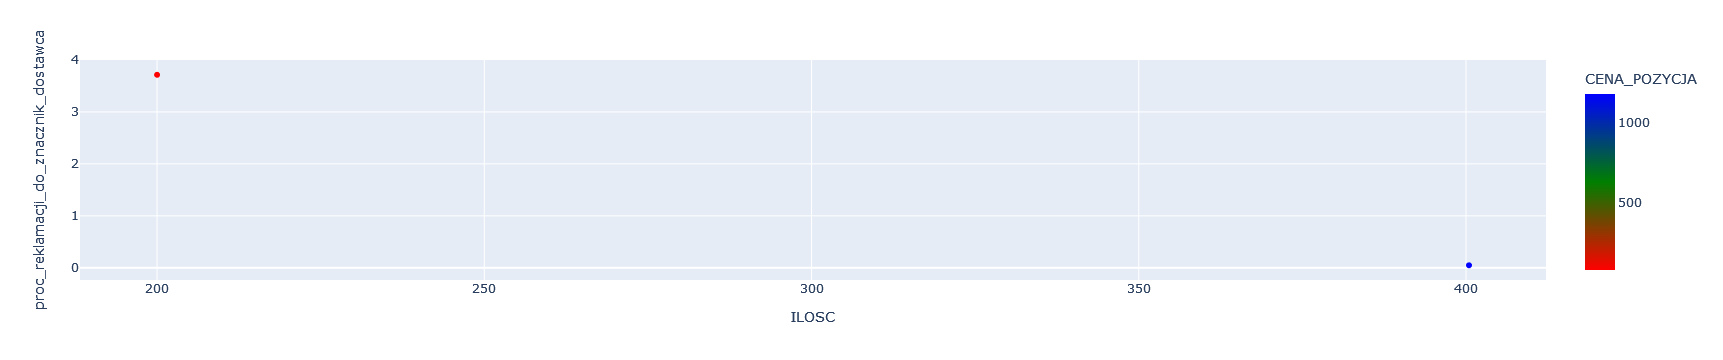

In [26]:
func_cluster(df_fi_sell, 'TAŚMY', 'OUTLET')

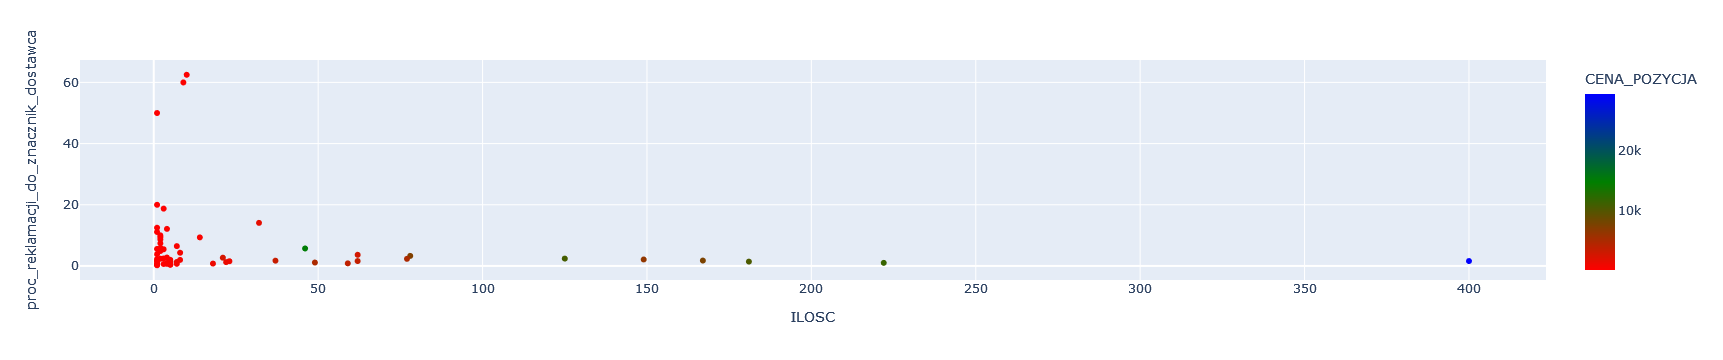

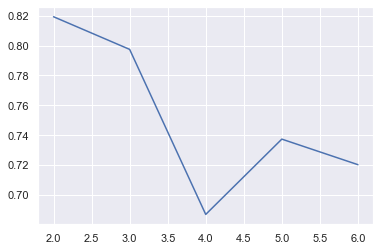

,NAZWA_ZNACZNIK,ANALIT02,DOSTAWCA,pred_cluster
312,CERAMIKA,LIKWIDACJA,,0
322,CERAMIKA,LIKWIDACJA,6788,0
355,CERAMIKA,LIKWIDACJA,10863,0
359,CERAMIKA,LIKWIDACJA,10872,0
360,CERAMIKA,LIKWIDACJA,10875,0
...,...,...,...,...
620,CERAMIKA,LIKWIDACJA,H76950,0
622,CERAMIKA,LIKWIDACJA,I16019,0
629,CERAMIKA,LIKWIDACJA,J24700,1
630,CERAMIKA,LIKWIDACJA,J25206,0


In [27]:
func_cluster(df_fi_sell, 'CERAMIKA', 'LIKWIDACJA')

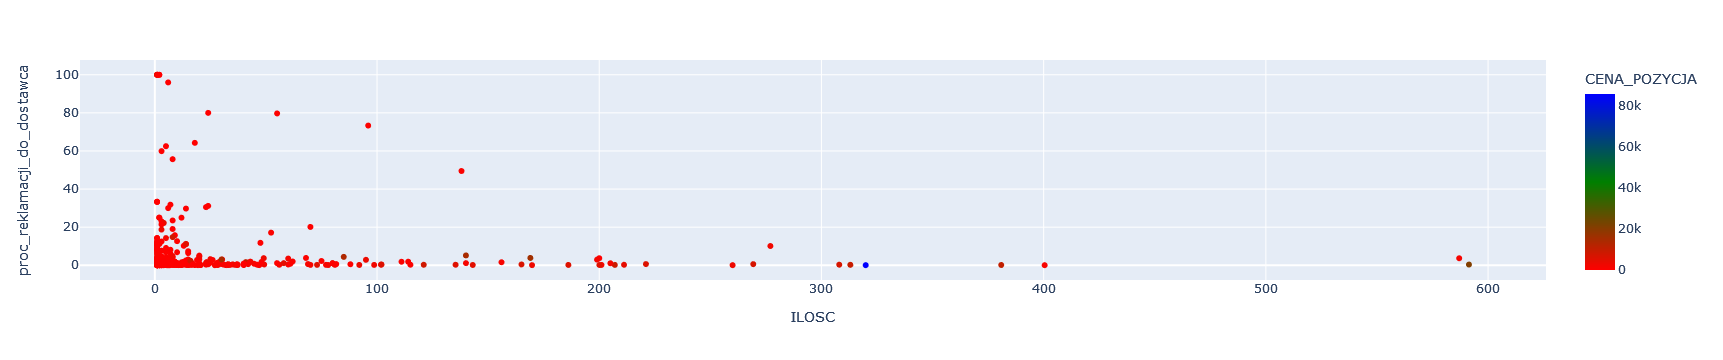

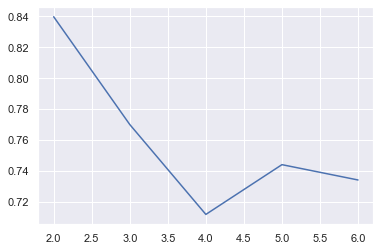

In [28]:
func_cluster(df_fi_sell, '', 'OUTLET',1)

In [404]:
df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].groupby(['ANALIT01','FAKTURA']).agg({'WARTOSC_B':'first'}).reset_index().\
                                                        groupby(['ANALIT01']).agg({'WARTOSC_B':'sum',
                                                                                  'FAKTURA':'nunique'})

,WARTOSC_B,FAKTURA
ANALIT01,,
FE,210587.19,674
LI,261213.17,2120
OU,466766.84,3517


In [400]:
df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].groupby(['ANALIT01']).agg({'FAKTURA':'nunique'})

,FAKTURA
ANALIT01,
FE,674
LI,2120
OU,3517


In [402]:
df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])]['FAKTURA'].nunique()

6311

In [421]:
df_fi

,FAKTURA,FAKTURA_FK,Z_DNIA,WARTOSC_B,KOD,OPIS,NAZWA,RODZAJ,KOD_TEMA,ILOSC,FAKTURA_NUMER,ZNACZNIK,DOSTAWCA,NAZWA_ZNACZNIK,year,month,day_of_year,week,week_day,year_month,year_week,year_day,ANALIT01,ANALIT02,sprzedaz_calego_dostawcy,sprzedaz_calego_dostawcy_ilosc,sprzedaz_znacznik_dostawcy,sprzedaz_znacznik_dostawcy_ilosc,sprzedaz_kod_tema_dostawcy,sprzedaz_kod_tema_dostawcy_ilosc
0,MM5600129162,,2022-01-28,86.22,LI,44,ZAS/SPECIAL/B,140X250 78,204218,2.0,00129162,3.0,10677,ZAS.GOTOWE,2022,1,28,4,5,2022-01-01,2022--04,2022--028,LI,LIKWIDACJA,2.921993e+04,1492.902778,1.469002e+04,399.000000,0.000000,0.0
1,MM5600129163,,2022-01-28,229.35,LI,44,ZAS/ELIE/B+RÓŻ,140X250 PRZEL,364657,1.0,00129163,3.0,F55032,ZAS.GOTOWE,2022,1,28,4,5,2022-01-01,2022--04,2022--028,LI,LIKWIDACJA,4.683334e+06,132798.307692,4.552218e+06,120570.307692,19979.050000,458.0
2,MM5600129163,,2022-01-28,229.35,LI,44,FIR/ESIM/B,140X250 PRZEL,333886,1.0,00129163,3.0,11447,ZAS.GOTOWE,2022,1,28,4,5,2022-01-01,2022--04,2022--028,LI,LIKWIDACJA,5.858700e+06,148951.900000,5.509876e+06,126138.250000,41606.936328,1700.0
3,MM5600129163,,2022-01-28,229.35,LI,44,ZAS/MARIAH/K+MU,140X250 PRZEL,371969,1.0,00129163,3.0,12459,ZAS.GOTOWE,2022,1,28,4,5,2022-01-01,2022--04,2022--028,LI,LIKWIDACJA,3.201503e+06,93504.380000,2.753323e+06,72535.000000,25923.760000,595.0
4,MM5600129163,,2022-01-28,229.35,LI,44,FIR/SEYLAN/B+SRE,140X250 PRZEL,326708,1.0,00129163,3.0,F55032,ZAS.GOTOWE,2022,1,28,4,5,2022-01-01,2022--04,2022--028,LI,LIKWIDACJA,4.683334e+06,132798.307692,4.552218e+06,120570.307692,9552.220000,310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67128,MM5600149969,,2022-07-19,1986.19,00,11,PIER/ZAS/SIBEL,140X270 T K,378076,2.0,00149969,3.0,H00846,ZAS.GOTOWE,2022,7,200,29,2,2022-07-01,2022--29,2022--200,00,MAGAZYN_00,7.030572e+06,226057.713131,6.389317e+06,176241.000000,37792.420000,759.0
67129,MM5600149969,,2022-07-19,1986.19,00,11,ZAS/DAVOS/B+ZIE,140X250 PRZEL,373048,5.0,00149969,3.0,H00846,ZAS.GOTOWE,2022,7,200,29,2,2022-07-01,2022--29,2022--200,00,MAGAZYN_00,7.030572e+06,226057.713131,6.389317e+06,176241.000000,280526.160000,5177.0
67130,MM5600149969,,2022-07-19,1986.19,00,11,ZAS/MELANIE/GRAF,140X250 PRZEL,373407,5.0,00149969,3.0,H00846,ZAS.GOTOWE,2022,7,200,29,2,2022-07-01,2022--29,2022--200,00,MAGAZYN_00,7.030572e+06,226057.713131,6.389317e+06,176241.000000,46331.900000,1301.0
67131,MM5600149969,,2022-07-19,1986.19,00,11,D91/Z/POLI/CZ+ZŁ,140X250 PRZEL,372581,1.0,00149969,3.0,F55032,ZAS.GOTOWE,2022,7,200,29,2,2022-07-01,2022--29,2022--200,00,MAGAZYN_00,4.683334e+06,132798.307692,4.552218e+06,120570.307692,61.780000,2.0


In [420]:
df_szac_bez_duplikatow=pd.DataFrame()
brak_zmiany_ceny=0
zmiana_ceny=0
ind_zmiana_ceny=[]
for fakt in tqdm(df_szac['FAKTURA'].unique()):
    for nazwa in df_szac.loc[df_szac['FAKTURA']==fakt]['NAZWA1_BEZ_F'].unique():
        if len(df_szac.loc[df_szac['FAKTURA']==fakt].loc[df_szac['NAZWA1_BEZ_F']==nazwa])>1:
            ind=df_szac.loc[df_szac['FAKTURA']==fakt].loc[df_szac['NAZWA1_BEZ_F']==nazwa].index
            if df_szac.loc[ind[0], 'CENA_Z1']!=df_szac.loc[ind[1], 'CENA_Z2']:
                zmiana_ceny+=1
                ind_zmiana_ceny=np.append(ind_zmiana_ceny, ind)
            else: brak_zmiany_ceny+=1
        else: continue


100%|██████████████████████████████████████████████████████████████████████████████| 4134/4134 [00:45<00:00, 91.49it/s]


In [411]:
brak_zmiany_ceny

4399

In [414]:
zmiana_ceny

174

In [419]:
df_szac.loc[df_szac['CENA_Z1']!=df_szac['CENA_Z2']]

,FAKTURA,FK,Z_DNIA,OPIS,TYP_PRZESZ,UZASADNIEN,NAZWA1,NAZWA2,RODZAJ1,RODZAJ2,KOD_TEMA,ILOSC1,ILOSC2,CENA_Z1,CENA_Z2,FAKTURA_NUMER,ZNACZNIK,DOSTAWCA,NAZWA_ZNACZNIK,year,month,day_of_year,week,week_day,year_month,year_week,year_day,NAZWA1_BEZ_F


In [417]:
df_szac.loc[ind_zmiana_ceny].head(50)

,FAKTURA,FK,Z_DNIA,OPIS,TYP_PRZESZ,UZASADNIEN,NAZWA1,NAZWA2,RODZAJ1,RODZAJ2,KOD_TEMA,ILOSC1,ILOSC2,CENA_Z1,CENA_Z2,FAKTURA_NUMER,ZNACZNIK,DOSTAWCA,NAZWA_ZNACZNIK,year,month,day_of_year,week,week_day,year_month,year_week,year_day,NAZWA1_BEZ_F
2193,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/KW/SUZI1/CZER,SW/KW/SUZI1/CZER,18CM CZER+B,18CM CZER+B,221045,18,0,1.12,1.12,00034322,10.0,7755,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/SUZI1/CZER
2195,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/KW/SUZI1/CZER,SW/KW/SUZI1/CZER,18CM CZER+B,18CM CZER+B,126521,37,0,2.83,2.83,00034322,10.0,12762,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/SUZI1/CZER
2194,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/KW/SUZI1/CZ,F/SW/KW/SUZI1/CZ,18CM CZER+B,18CM CZER+B,320272,0,18,1.12,1.12,00034322,10.0,7755,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/SUZI1/CZ
2196,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/KW/SUZI1/CZ,F/SW/KW/SUZI1/CZ,18CM CZER+B,18CM CZER+B,407341,0,37,2.83,2.83,00034322,10.0,12762,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/SUZI1/CZ
2199,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/KW/WOLLY/CZER,SW/KW/WOLLY/CZER,18CM CZER,18CM CZER,221047,11,0,1.55,1.55,00034322,10.0,7755,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/WOLLY/CZER
2201,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/KW/WOLLY/CZER,SW/KW/WOLLY/CZER,18CM CZER,18CM CZER,126525,25,0,4.50,4.50,00034322,10.0,12762,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/WOLLY/CZER
2200,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/KW/WOLLY/CZ,F/SW/KW/WOLLY/CZ,18CM CZER,18CM CZER,310819,0,11,1.55,1.55,00034322,10.0,7755,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/WOLLY/CZ
2202,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/KW/WOLLY/CZ,F/SW/KW/WOLLY/CZ,18CM CZER,18CM CZER,313626,0,25,4.50,4.50,00034322,10.0,12762,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/WOLLY/CZ
263,SC5600034236,T,2022-01-28,Zmiana stanu,0,,SW/B/STR/29A,SW/B/STR/29A,8CM SZAMP,8CM SZAMP,370433,1,0,3.64,3.64,00034236,10.0,11794,ŚWIĘTA,2022,1,28,4,5,2022-01-01,2022--04,2022--028,SW/B/STR/29A
264,SC5600034236,T,2022-01-28,Zmiana stanu,0,,SW/B/STR/29A,SW/B/STR/29A,8CM SZAMP,8CM SZAMP,370433,3,4,2.19,2.19,00034236,10.0,11794,ŚWIĘTA,2022,1,28,4,5,2022-01-01,2022--04,2022--028,SW/B/STR/29A


In [418]:
df_szac

,FAKTURA,FK,Z_DNIA,OPIS,TYP_PRZESZ,UZASADNIEN,NAZWA1,NAZWA2,RODZAJ1,RODZAJ2,KOD_TEMA,ILOSC1,ILOSC2,CENA_Z1,CENA_Z2,FAKTURA_NUMER,ZNACZNIK,DOSTAWCA,NAZWA_ZNACZNIK,year,month,day_of_year,week,week_day,year_month,year_week,year_day,NAZWA1_BEZ_F
0,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/OZD/AMARO/0,F/SW/OZD/AMARO/0,20CM CZER KONIK,20CM CZER KONIK,313339,0,1,16.20,16.20,00034322,10.0,12420,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/OZD/AMARO/0
1,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/OZD/MAT/5,SW/OZD/MAT/5,19X22CM BORD,19X22CM BORD,348575,2,0,2.68,2.68,00034322,10.0,12604,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/OZD/MAT/5
2,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/OZD/MAT/5,F/SW/OZD/MAT/5,19X22CM BORD,19X22CM BORD,365980,0,2,2.68,2.68,00034322,10.0,12604,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/OZD/MAT/5
3,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/OZD/KENDAL/2,SW/OZD/KENDAL/2,15CM BORD,15CM BORD,320193,2,0,2.85,2.85,00034322,10.0,F29732,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/OZD/KENDAL/2
4,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/OZD/KENDAL/,F/SW/OZD/KENDAL/,15CM BORD,15CM BORD,407354,0,2,2.85,2.85,00034322,10.0,F29732,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/OZD/KENDAL/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13569,SC5600036594,N,2022-05-16,Przecena towaru,8,Na podstawie korekty: ZF5600176809,1070A/MARK/B,1070A/MARK/B,300,300,315750,"3,55",0,5.50,5.50,00036594,60.0,H19851,Hit BAZA,2022,5,136,20,1,2022-05-01,2022--20,2022--136,1070A/MARK/B
13570,SC5600036594,N,2022-05-16,Przecena towaru,8,Na podstawie korekty: ZF5600176809,F/1070A/MARK/B,F/1070A/MARK/B,300,300,327281,0,"3,55",5.50,5.50,00036594,1.0,H19851,BELKI,2022,5,136,20,1,2022-05-01,2022--20,2022--136,1070A/MARK/B
13571,SC5600036595,N,2022-05-16,Przecena towaru,8,Na podstawie korekty: ZF5600175222,FIR/LUCY/B,FIR/LUCY/B,140X250 PRZE,140X250 PRZE,224664,1,0,10.77,10.77,00036595,3.0,F05458,ZAS.GOTOWE,2022,5,136,20,1,2022-05-01,2022--20,2022--136,FIR/LUCY/B
13572,SC5600036595,N,2022-05-16,Przecena towaru,8,Na podstawie korekty: ZF5600175222,F/FIR/LUCY/B,F/FIR/LUCY/B,140X250 PRZE,140X250 PRZE,320766,0,1,10.77,10.77,00036595,3.0,F05458,ZAS.GOTOWE,2022,5,136,20,1,2022-05-01,2022--20,2022--136,FIR/LUCY/B


# inne

In [218]:
_s=pd.read_csv('../sprzedaz_fakty_bi/hurtbi_fakty_sprz_22.csv',encoding='Cp1250',
              sep="|")

In [142]:
_z=pd.read_csv('../słowniki/znacznik.csv',encoding='Cp1250',
              sep="|")[['ZNACZNIK','NAZWA']]

In [144]:
_z.loc[_z['ZNACZNIK']==91]

,ZNACZNIK,NAZWA
38,91,USŁUGI SZYCIA


In [203]:
_=pd.read_csv('../słowniki/slownik.csv',encoding='Cp1250',
              sep="|")#[['KOD_TEMA','ZNACZNIK','DOSTAWCA']]

In [145]:
_=_.merge(_z, how='left',on='ZNACZNIK')

In [140]:
np.sort(_['KOD_TEMA'].unique())

array([-10056, -10055, -10054, ..., 999997, 999998, 999999], dtype=int64)

In [147]:
_.loc[_['KOD_TEMA']<0]['NAZWA'].unique()

array(['INNE', 'USŁUGI SZYCIA', 'USŁUGI TRANSPORT', 'USŁUGI POS',
       'KARNISZE', 'USŁUGI INNE', 'USŁUGI ZAKUP', 'USŁUGI MONTAŻ',
       'USŁUGI ROLETY'], dtype=object)

In [149]:
pd.read_csv('../sprzedaz_fakty_bi/hurtbi_fakty_sprz_22.csv',encoding='Cp1250',
              sep="|")

,FAKTURA,DOKUMENT,Z_DNIA,FILIA,KOD_TEMA,TYP_DOK,JAK_POWST,WARTOB,ILOSC
0,FVM200002309,FM2A22/00002,22/01/03,M2,-10000.0,FV,K,0,0
1,FVM200002309,FM2A22/00002,22/01/03,M2,378079.0,FV,K,424,"10,6"
2,FVM200002309,FM2A22/00002,22/01/03,M2,378911.0,FV,K,340,"8,5"
3,FVM200002309,FM2A22/00002,22/01/03,M2,65080.0,FV,K,452,20
4,FVM200002309,FM2A22/00002,22/01/03,M2,50502.0,FV,K,44,200
...,...,...,...,...,...,...,...,...,...
536295,KV0000121311,KF0022/09742,22/03/28,0.0,3895.0,KV,ZI2O#,"-26,25",-1
536296,KV0000119927,KF0022/08378,22/03/16,0.0,387969.0,KV,Z,"-64,98",-1
536297,KV0000120112,KF0022/08563,22/03/17,0.0,62937.0,KV,ZI2O#,"-79,19","-5,6"
536298,KV0000117196,KF0022/05726,22/03/03,0.0,93844.0,KV,A,"-1,88",-1


In [88]:
import cx_Oracle

try:
    host = '192.168.0.206'
    port = 1521
    SID = 'orcl'
    
    dsn = cx_Oracle.makedsn(host, port, SID)
    
    connection = cx_Oracle.connect(user="EF_KG",
                                  password='',
                                  dsn=dsn,
                                   encoding="UTF-8")

    # show the version of the Oracle Database
    print(connection.version)
except cx_Oracle.Error as error:
    print(error)
finally:
    # release the connection
    if connection:
        connection.close()


DPI-1047: Cannot locate a 64-bit Oracle Client library: "The specified module could not be found". See https://cx-oracle.readthedocs.io/en/latest/user_guide/installation.html for help


NameError: name 'connection' is not defined